In [1]:
from src.EPInformer.models_abc import EPInformer_v1, EPInformer_v2, enhancer_predictor_256bp
from src.scripts.utils import prepare_input
import src.scripts.utils_forTraining as train
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import torch
from torch.utils.data import Subset, Dataset
import torch.utils.data as data_utils
from sklearn.metrics import mean_squared_error
import h5py
import kipoiseq

In [ ]:
# # Download GM12878 data from Zenodo
# !wget https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip -P ./data/
# !wget https://zenodo.org/records/12738705/files/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated.zip -P ./data/
# !unzip -o -qq ./data/K562_DNase_ENCFF257HEE_2kb_4DNFITUOMFUQ_enhancer_promoter_encoding.h5.zip -d ./data/
# !unzip -o -qq ./data/K562_DNase_ENCFF257HEE_hic_4DNFITUOMFUQ_1MB_ABC_nominated.zip -d ./data/

In [2]:
class promoter_enhancer_dataset(Dataset):
    def __init__(self, data_dir, cell_type='K562', expr_type='RNA', n_enh_feats=3, disable_enh=False, distance_thr=None, max_n_enh=200, use_prm_signal=False, rm_prm_seq=False):
        # self.data_h5 = h5py.File('/mnt/usb1/jiecong/{}_220CREs-gene_strand.hdf5'.format(cell_type), 'r') # /mnt/usb1/jiecong
        self.data_h5 = h5py.File(data_dir + '/{}_200CREs-gene_RPM_4feats.hdf5'.format(cell_type), 'r')
        self.rm_prm_seq = rm_prm_seq
        self.cell_type = cell_type
        self.n_enh_feats = n_enh_feats
        self.expr_type = expr_type
        self.disable_enh = disable_enh
        self.distance_thr = distance_thr
        self.max_n_enh = max_n_enh
        self.use_prm_signal = use_prm_signal
        # self.expr_df = pd.read_csv('./data/GM12878_K562_18377_gene_expr_fromXpresso.csv', index_col='gene_id')
        self.expr_df = pd.read_csv('./data/GM12878_K562_18377_gene_expr_fromXpresso_with_sequence_strand.csv', index_col='gene_id')
        # self.cell2tok = {'K562':0, 'GM12878':1, 'HepG2':2,}
        if cell_type == 'K562':
            promoter_df = pd.read_csv(data_dir + '/K562_ABC_EGLinks/DNase_ENCFF257HEE_Neighborhoods/GeneList.txt', sep='\t', index_col='name')
        elif cell_type == 'GM12878':
            promoter_df = pd.read_csv(data_dir + '/GM12878_ABC_EGLinks/DNase_ENCFF020WZB_Neighborhoods/GeneList.txt', sep='\t', index_col='name')
        elif cell_type == 'HepG2':
            promoter_df = pd.read_csv(data_dir + '/HepG2_ABC_EGLinks/DNase_ENCFF691HJY_Neighborhoods/GeneList.txt', sep='\t', index_col='name')
        else:
            print('Cell not found!')
        promoter_df['promoter_activity'] = np.sqrt(promoter_df['DHS.RPKM.TSS1Kb']*promoter_df['H3K27ac.RPKM.TSS1Kb'])
        self.promoter_df = promoter_df

    def __len__(self):
        return len(self.data_h5['ensid'])
    def __getitem__(self, idx):
        sample_ensid = self.data_h5['ensid'][idx].decode()
        enh_ohe = self.data_h5['enhancers_ohe'][idx]
        enh_feats = self.data_h5['enhancers_feat'][idx][:,:]
        prm_seq = self.expr_df.loc[sample_ensid, 'promoter_2k']
        prm_ohe = one_hot_encode(prm_seq)[np.newaxis,:]
        prm_signal = np.log(1+np.array([self.promoter_df.loc[sample_ensid, 'promoter_activity']]))
        if self.n_enh_feats == 0:
            enh_feats = np.zeros_like(np.concatenate([abs(enh_feats[:, [0]]), enh_feats[:, [3]], enh_feats[:, [-1]]], axis=1)[:,:1])
        else:
            enh_feats = np.concatenate([abs(enh_feats[:, [0]]), enh_feats[:, [3]], enh_feats[:, [-1]]], axis=1)[:,:self.n_enh_feats]
        rna_feats = np.array(self.expr_df.loc[sample_ensid][['UTR5LEN_log10zscore','CDSLEN_log10zscore','INTRONLEN_log10zscore',
                             'UTR3LEN_log10zscore','UTR5GC','CDSGC','UTR3GC', 'ORFEXONDENSITY']].values.astype(float)).flatten()
        if self.use_prm_signal:
            rna_feats = np.concatenate([rna_feats, prm_signal])
        if self.distance_thr is not None: 
            enh_ohe_new = np.zeros((self.max_n_enh, 2000, 4))
            enh_feats_new = np.zeros((self.max_n_enh, enh_feats.shape[-1]))
            new_i = 0
            for i in range(enh_ohe.shape[0]):
                if not self.rm_prm_seq:
                    if abs(enh_feats[i][0])<=self.distance_thr:
                        # enh_ohe[i] = np.zeros_like(enh_ohe[i])
                        enh_ohe_new[new_i] = enh_ohe[i]
                        enh_feats_new[new_i] = enh_feats[i]
                        new_i += 1
                else:
                    if abs(enh_feats[i][0])<=self.distance_thr and abs(enh_feats[i][0])>=1000:
                        # enh_ohe[i] = np.zeros_like(enh_ohe[i])
                        enh_ohe_new[new_i] = enh_ohe[i]
                        enh_feats_new[new_i] = enh_feats[i]
                        new_i += 1
                if new_i >= self.max_n_enh:
                    break
            enh_ohe = enh_ohe_new
            enh_feats = enh_feats_new
        if self.disable_enh:
            enh_ohe = np.zeros_like(enh_ohe)
            enh_feats = np.zeros_like(enh_feats)
        if self.expr_type == 'CAGE':
            expr = np.log10(self.expr_df.loc[sample_ensid, self.cell_type + '_CAGE_128*3_sum']+1)
        else:
            expr = self.expr_df.loc[sample_ensid, 'Actual_' + self.cell_type]
        pe_ohe = np.concatenate([prm_ohe, enh_ohe], axis=0)
        prm_feats = np.ones_like(enh_feats[[0]])
        if self.use_prm_signal and self.n_enh_feats == 3:
            prm_feats[0, 1] = prm_signal
        pe_feats = np.concatenate([prm_feats, enh_feats], axis=0)
        return pe_ohe, rna_feats, pe_feats, expr, sample_ensid

def test(net, test_ds, fold_i, model_name = None, saved_model_path=None, batch_size=64, device='cuda', model_type='best'):
    testloader = data_utils.DataLoader(test_ds, batch_size=batch_size, pin_memory=True, num_workers=0)
    if saved_model_path is not None:
        checkpoint = torch.load(saved_model_path + "/fold_" + str(fold_i) + "_best_"+model_name+"_checkpoint.pt", weights_only=False)
        net.load_state_dict(checkpoint['model_state_dict'])
        print(model_name,'loaded!')
    net.eval()
    with torch.no_grad():
        preds = []
        actual = []
        ensid_list = []
        for data in tqdm(testloader):
            pe_seqs, rna_feats, enh_feats, y_expr, eid = data
            pe_seqs = pe_seqs.float().to(device)
            if net.useFeat:
                rna_feats = rna_feats.float().to(device)
            else:
                rna_feats = None
            enh_feats = enh_feats.float().to(device)
            y_expr = y_expr.float().to(device)
            pred_expr, _ = net(pe_seqs, enh_feats=enh_feats, rna_feats=rna_feats)
            outputs = list(pred_expr.flatten().cpu().detach().numpy())
            labels = list(y_expr.flatten().cpu().detach().numpy())
            preds += outputs
            actual += labels
            ensid_list += eid

    slope, intercept, r_value, p_value, std_err = stats.linregress(preds, actual)
    peasonr, pvalue = stats.pearsonr(preds, actual)
    mse = mean_squared_error(preds, actual)
    # print(fold %s test sequence: %0.3f' % (fold_i, r_value**2))
    print('\nPearson R:', peasonr)
    # sys.stdout.flush()
    df = pd.DataFrame(index=np.array(ensid_list).flatten())
    df['Pred'] = preds
    df['actual'] = actual
    df['fold_idx'] = fold_i
    pearsonr_we, pvalue = stats.pearsonr(df['Pred'], df['actual'])
    # print('PearsonR:', pearsonr_we)
    if saved_model_path is not None:
        df.to_csv(saved_model_path + "/fold_" + str(fold_i) + "_"+ model_name + "_predictions.csv")
    return df

def one_hot_encode(sequence):
    return kipoiseq.transforms.functional.one_hot_dna(sequence, neutral_value=0.0).astype(np.float32)

In [ ]:
# Download K562 training data from Zenodo 
# !wget https://zenodo.org/records/13233337/files/K562_200CREs-gene_RPM_4feats.hdf5.gz -P ./data/
# !wget https://zenodo.org/records/13233337/files/K562_ABC_EGLinks.zip -P ./data/
# !gunzip -o -qq ./data/K562_200CREs-gene_RPM_4feats.hdf5.gz -d ./data/
# !unzip -o -qq ./data/K562_ABC_EGLinks.zip -d ./data/

## Predict K562 CAGE/RNA-seq expression using EPInformer-EP-Activity

In [3]:
cell = 'K562'
split_df = pd.read_csv('./data/leave_chrom_out_crossvalidation_split_18377genes.csv', index_col=0)
distance_threshold = 100_000
n_enhancers = 60
device = 'mps' # cuda if torch.cuda.is_available() else 'cpu'
num_feature = 2  # EPInformer-PE-Activity: 2 (Distance + Activity); EPInformer-PE-Activity-HiC: 3 (Distance + Activity + HiC)
batch_size = 16
expr_type = 'CAGE'
prediction_res = []
data_dir = '../data_EPInformer'
for expr_type in ['CAGE', 'RNA']:
    for fi in range(1, 13):
        print('cell', cell, 'expression type:', expr_type)
        print("-"*10, 'fold', fi, '-'*10)
        fold_i = 'fold_' + str(fi)
        train_ensid = split_df[split_df[fold_i] == 'train'].index
        valid_ensid = split_df[split_df[fold_i] == 'valid'].index
        test_ensid = split_df[split_df[fold_i] == 'test'].index
        # all_ds = promoter_enhancer_dataset(expr_type=expr_type, cell_type=cell, n_extraFeat=n_extraFeat, 
        #     usePromoterSignal=True, n_enhancers=n_enhancers, distance_threshold=distance_threshold, data_folder =data_dir)
        all_ds = promoter_enhancer_dataset(data_dir='../data_EPInformer/',cell_type=cell, expr_type=expr_type, n_enh_feats=num_feature, distance_thr=100_000, 
            max_n_enh=n_enhancers, use_prm_signal=False)
        ensid_list = [eid.decode() for eid in all_ds.data_h5['ensid'][:]]
        ensid_df = pd.DataFrame(ensid_list, columns=['ensid'])
        ensid_df['idx'] = np.arange(len(ensid_list))
        ensid_df = ensid_df.set_index('ensid')
        train_idx = ensid_df.loc[train_ensid]['idx']
        valid_idx = ensid_df.loc[valid_ensid]['idx']
        test_idx = ensid_df.loc[test_ensid]['idx']
        train_ds = Subset(all_ds, train_idx)
        valid_ds = Subset(all_ds, valid_idx)
        test_ds = Subset(all_ds, test_idx)
        model = EPInformer_v2(n_encoder=3, n_enhancer=n_enhancers, out_dim=64, n_extraFeat=num_feature, useBN=False, device=device, usePromoterSignal=False)
        model = model.to(device)
        # model_name= 'tunedEPInformerV2.preTrainedConv.4base.64dim.3Trans.4head.TrueBN.TrueLN.TrueFeat.3extraFeat.60enh.K562.rmEnhNone.bs16.seq_feat_dist.DNaseH.distanceDist100k.hic0.len2k.distance.{}'.format(expr_type)
        checkpoint = torch.load("./trained_models/expression_models/EPInformer_v2_PE_Activity/fold_{}.EPInformer-PE-Activity.K562.{}.checkpoint.pt".format(fi, expr_type),weights_only=False,  map_location=device)
        # model_path = "/content/drive/MyDrive/EPInformer/EPInformer_activity/models_allInOne/fold_{}_best_{}_checkpoint.pt".format(fi, model_name)
        # checkpoint = torch.load(model_path)
        # try:
        model.load_state_dict(checkpoint['model_state_dict'])
        # except:
        #     continue
        test_df = test(model, test_ds, fold_i=fi, batch_size=batch_size, device=device)
        test_df['expr_type'] = expr_type
        prediction_res.append(test_df)
prediction_res = pd.concat(prediction_res)

cell K562 expression type: CAGE
---------- fold 1 ----------


100%|██████████| 137/137 [00:17<00:00,  7.95it/s]



Pearson R: 0.8790977
cell K562 expression type: CAGE
---------- fold 2 ----------


100%|██████████| 83/83 [00:10<00:00,  8.10it/s]



Pearson R: 0.8908372
cell K562 expression type: CAGE
---------- fold 3 ----------


100%|██████████| 82/82 [00:10<00:00,  7.71it/s]



Pearson R: 0.8770988
cell K562 expression type: CAGE
---------- fold 4 ----------


100%|██████████| 86/86 [00:11<00:00,  7.45it/s]



Pearson R: 0.8989308
cell K562 expression type: CAGE
---------- fold 5 ----------


100%|██████████| 108/108 [00:14<00:00,  7.40it/s]



Pearson R: 0.86883247
cell K562 expression type: CAGE
---------- fold 6 ----------


100%|██████████| 118/118 [00:17<00:00,  6.60it/s]



Pearson R: 0.879839
cell K562 expression type: CAGE
---------- fold 7 ----------


100%|██████████| 56/56 [00:08<00:00,  6.93it/s]



Pearson R: 0.9014396
cell K562 expression type: CAGE
---------- fold 8 ----------


100%|██████████| 128/128 [00:17<00:00,  7.24it/s]



Pearson R: 0.87365246
cell K562 expression type: CAGE
---------- fold 9 ----------


100%|██████████| 76/76 [00:10<00:00,  7.13it/s]



Pearson R: 0.8772849
cell K562 expression type: CAGE
---------- fold 10 ----------


100%|██████████| 89/89 [00:12<00:00,  7.11it/s]



Pearson R: 0.8804389
cell K562 expression type: CAGE
---------- fold 11 ----------


100%|██████████| 73/73 [00:10<00:00,  6.97it/s]



Pearson R: 0.84778297
cell K562 expression type: CAGE
---------- fold 12 ----------


100%|██████████| 119/119 [00:19<00:00,  6.02it/s]



Pearson R: 0.90641046
cell K562 expression type: RNA
---------- fold 1 ----------


100%|██████████| 137/137 [00:27<00:00,  4.99it/s]



Pearson R: 0.8681365
cell K562 expression type: RNA
---------- fold 2 ----------


100%|██████████| 83/83 [00:27<00:00,  3.07it/s]



Pearson R: 0.8798548
cell K562 expression type: RNA
---------- fold 3 ----------


100%|██████████| 82/82 [00:27<00:00,  3.03it/s]



Pearson R: 0.8665953
cell K562 expression type: RNA
---------- fold 4 ----------


100%|██████████| 86/86 [00:25<00:00,  3.38it/s]



Pearson R: 0.88306177
cell K562 expression type: RNA
---------- fold 5 ----------


100%|██████████| 108/108 [00:27<00:00,  3.93it/s]



Pearson R: 0.845024
cell K562 expression type: RNA
---------- fold 6 ----------


100%|██████████| 118/118 [00:30<00:00,  3.87it/s]



Pearson R: 0.8586458
cell K562 expression type: RNA
---------- fold 7 ----------


100%|██████████| 56/56 [00:15<00:00,  3.59it/s]



Pearson R: 0.89054036
cell K562 expression type: RNA
---------- fold 8 ----------


100%|██████████| 128/128 [00:31<00:00,  4.13it/s]



Pearson R: 0.8296698
cell K562 expression type: RNA
---------- fold 9 ----------


100%|██████████| 76/76 [00:16<00:00,  4.71it/s]



Pearson R: 0.8629254
cell K562 expression type: RNA
---------- fold 10 ----------


100%|██████████| 89/89 [00:19<00:00,  4.50it/s]



Pearson R: 0.87109935
cell K562 expression type: RNA
---------- fold 11 ----------


100%|██████████| 73/73 [00:17<00:00,  4.24it/s]



Pearson R: 0.7840323
cell K562 expression type: RNA
---------- fold 12 ----------


100%|██████████| 119/119 [00:28<00:00,  4.18it/s]


Pearson R: 0.87646997


In [56]:
prediction_res_gene = prediction_res.merge(split_df[['Gene name']], left_index=True, right_index=True).reset_index()

<Figure size 600x600 with 0 Axes>

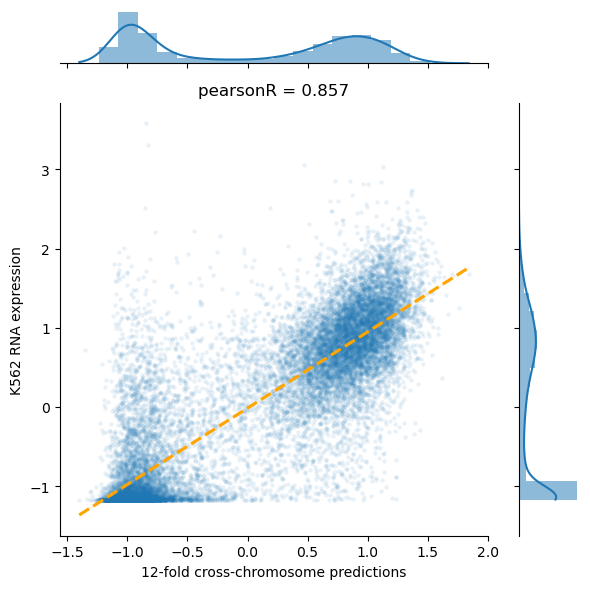

In [6]:
plt.figure(figsize=(6,6))
expr_type = 'RNA'
prediction_assay_spec = prediction_res[prediction_res['expr_type']==expr_type].reset_index(drop=True)
pearsonR, pv = stats.pearsonr(prediction_assay_spec['Pred'], prediction_assay_spec['actual'])
ax = sns.jointplot(
    data=prediction_assay_spec,
    x="Pred",
    y="actual",
    kind = 'scatter',
    joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
    marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
)
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearsonR))
plt.ylabel('K562 {} expression'.format(expr_type))
plt.xlabel('12-fold cross-chromosome predictions')
plt.tight_layout()
plt.savefig('../EPInformer_v2_PE_Activity_K562_RNA.png', bbox_inches='tight', dpi=600)

<Figure size 600x600 with 0 Axes>

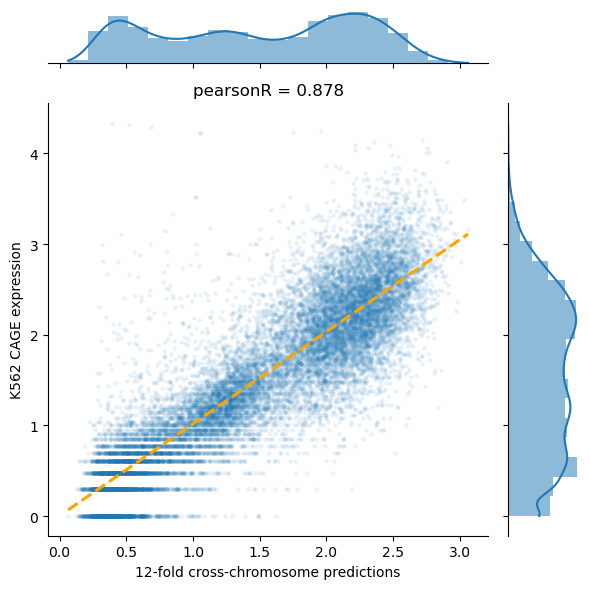

In [5]:
plt.figure(figsize=(6,6))
expr_type = 'CAGE'
prediction_assay_spec = prediction_res[prediction_res['expr_type']==expr_type].reset_index(drop=True)
pearsonR, pv = stats.pearsonr(prediction_assay_spec['Pred'], prediction_assay_spec['actual'])
ax = sns.jointplot(
    data=prediction_assay_spec,
    x="Pred",
    y="actual",
    kind = 'scatter',
    joint_kws={'marker':'o', 's':10, 'alpha':0.1, 'linewidth':0},
    marginal_kws={'bins':20, 'element':'step', 'kde':True, 'linewidth':0},
)
ax.plot_joint(sns.regplot, color="r", scatter=False, line_kws={"color": "orange", 'linestyle':'dashed'})
plt.title('pearsonR = {:.3f}'.format(pearsonR))
plt.ylabel('K562 {} expression'.format(expr_type))
plt.xlabel('12-fold cross-chromosome predictions')
plt.tight_layout()
plt.savefig('../EPInformer_v2_PE_Activity_K562_CAGE.png', bbox_inches='tight', dpi=600)